In [2]:
import os
import shutil
os.chdir('/content')
if os.path.isdir('./hetvae'):
  shutil.rmtree('./hetvae/')
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! git checkout optuna
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import pandas as pd
import importlib
import vae_models
importlib.reload(vae_models)
importlib.reload(models)
importlib.reload(utils)
from glob import glob
import matplotlib.pyplot as plt
import sys
#del sys.modules['dataset']
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 1892, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1892 (delta 19), reused 18 (delta 9), pack-reused 1860
Receiving objects: 100% (1892/1892), 25.97 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (622/622), done.
Branch 'optuna' set up to track remote branch 'optuna' from 'origin'.
Switched to a new branch 'optuna'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Pick your poison:

In [ ]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#-------------------------------
agn_file = '/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv'
agn_df = pd.read_csv(agn_file)
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)

AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part
AGN_1H2106 = AGN_1H2106.handle_dups().resample_dataset(num_samples=1).normalize(normalize_y_by='individual') \
  .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    AGN_1H2106.union_x.shape,
    AGN_1H2106.dataset.shape,
    AGN_1H2106.subsampled_mask.shape,
    AGN_1H2106.recon_mask.shape
  )


generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 5
new dataset length: 10
created union_x attribute of length 1450
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (10, 621, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(1450,) (10, 621, 3) (10, 621) (10, 621)


In [3]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')[:4]

# hypers: 
Edelson = DataSet().add_files(lc_files).files_to_numpy().handle_dups().resample_dataset(num_samples=1).normalize(normalize_y_by='individual') \
        .set_union_x().zero_fill().make_masks(frac=0.5)

print(
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )

dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
generating 1 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 8
created union_x attribute of length 665
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (8, 267, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(665,) (8, 267, 3) (8, 267) (8, 267)



## Setting up arguments

In [4]:
def define_model_args(trial):

    args = Namespace(
        batch_size = trial.suggest_categorical("batch_size", [8,16,32]),
        bound_variance = True,
        const_var = False,
        dataset='toy',
        dropout = trial.suggest_float("dropout", 0.0,0.5),
        elbo_weight = trial.suggest_float("elbo_weight", 0.0, 5.0),
        embed_time = trial.suggest_categorical("embed_time", [8,16,32,64,128]),
        enc_num_heads=1,
        intensity=True,
        k_iwae=1,
        kl_annealing=trial.suggest_categorical("kl_annealing", [True,False]),
        kl_zero=False, 
        latent_dim=trial.suggest_categorical("latent_dim", [8,16,32,64,128]),
        lr=trial.suggest_float("lr", 1e-7, 1e-1, log=True),
        mixing='concat', 
        mse_weight=trial.suggest_float("mse_weight",1,10),
        n=trial.suggest_categorical("n", [8,16,32,64,128]),
        net='hetvae', 
        niters=1000, 
        norm=True, 
        normalize_input='znorm', 
        num_ref_points=trial.suggest_categorical("num_ref_points", [8,16,32,64,128]),
        rec_hidden=trial.suggest_categorical("rec_hidden", [8,16,32,64,128]),
        recon_loss=False, 
        sample_tp= trial.suggest_float("sample_tp", 0.1,0.9), # will be ignored
        save=True, 
        seed=0, 
        shuffle=True, 
        std=0.1, 
        var_per_dim=False, 
        width=trial.suggest_categorical("width", [8,16,32,64,128])
    )



    return args






## **Generating Synthetic Data**

## **Loading HeTVAE model**

In [5]:
EPOCHS = 100
FILES = glob('/content/hetvae/data/EDELSON/*')[:4]
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)


In [13]:
def objective(trial):

    args = define_model_args(trial)

    seed = args.seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # dataset hyperparams
    num_samples=trial.suggest_int("num_samples", 1,10)
    normalize_y_by=trial.suggest_categorical("normalize_y_by", ["all", "individual"])

    Edelson = DataSet().add_files(FILES).files_to_numpy().handle_dups().resample_dataset(num_samples=num_samples).normalize(normalize_y_by=normalize_y_by) \
        .set_union_x().zero_fill().make_masks(frac=args.sample_tp)

    
    LightCurves = np.concatenate((Edelson.dataset, Edelson.subsampled_mask[:,:,np.newaxis], Edelson.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 

    print(LightCurves.shape)
    training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?
    
    

    train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
    
    
    net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x)) # , device="cuda"
    

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam","RMSprop", "SGD"])
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=args.lr)

    for epoch in range(EPOCHS):
        train(net, optimizer, epoch, train_loader, args, device=device)
        nll_loss = evaluate(net, valid_loader, device=device)
        trial.report(nll_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return nll_loss


In [14]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-06-07 21:05:06,532] A new study created in memory with name: no-name-ae63bc3b-3f47-4fb4-a033-76f434add996


dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
generating 10 new sample of each example in the dataset & appending them 
 old dataset length: 4
new dataset length: 44
created union_x attribute of length 665
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (44, 267, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(44, 267, 5)
Iter: 0, train loss: 10.3175, avg nll: 1.5630, avg kl: 3.2986, mse: 1.027224, mae: 0.818796
tensor(1.6009, device='cuda:0') NONE???
nll: 1.6009, mse: 1.0712, mae: 0.8368, mean_mse: 1.0712, mean_mae: 0.8368
tensor(1.5959, device='cuda:0') NONE???
nll: 1.5959, mse: 1.0685, mae: 0.8405, mean_mse: 1.0685, mean_mae: 0.8405
tensor(1.5908, device='cuda:0') NONE???
nll: 

KeyboardInterrupt: ignored

## **Training**

In [15]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:]
          error_bars = train_batch[:,:,2:3]
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1)
          


    # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x, # context_x, times
              context_y,             # context_y
              x, # target_x, same times? 
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=1,
              # optional, will be zero if not set
              error_bars = 1.   # masked_error_bars

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
      
        


In [10]:
def evaluate(net, train_loader, device="cuda"):
    train_loss = 0.
    train_n = 0.
    avg_loglik, mse, mae = 0,0,0
    mean_mae, mean_mse = 0,0
    with torch.no_grad():
        for i, train_batch in enumerate(train_loader):
            batch_len = train_batch.shape[0] 
            train_batch = train_batch.to(device)
            x = train_batch[:,:,0]
            y = train_batch[:,:,1:2]
            subsampled_mask = train_batch[:,:,3:4]
            recon_mask = train_batch[:,:,4:]
            error_bars = train_batch[:,:,2:3]
            seqlen = train_batch.size(1) 
            # subsampled flux values and their corresponding masks....
            context_y = torch.cat((
                y * subsampled_mask, subsampled_mask
            ), -1) 
            recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                    y * recon_mask, recon_mask
                ), -1)
            
            masked_error_bars = error_bars * subsampled_mask 


      # #   def compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
            loss_info = net.compute_unsupervised_loss(
                x, # context_x, times
                context_y,             # context_y
                x, # target_x, same times? 
                recon_context_y,
                num_samples=1, #???
                beta=1,
                # optional, will be zero if not set
                error_bars = 0.   # masked_error_bars

            )

            num_context_points = recon_mask.sum().item()
            mse += loss_info.mse * num_context_points
            mae += loss_info.mae * num_context_points
            mean_mse += loss_info.mean_mse * num_context_points
            mean_mae += loss_info.mean_mae * num_context_points
            avg_loglik += loss_info.mogloglik * num_context_points
            train_n += num_context_points
    print(-avg_loglik / train_n, "NONE???")
    print(
    'nll: {:.4f}, mse: {:.4f}, mae: {:.4f}, '
    'mean_mse: {:.4f}, mean_mae: {:.4f}'.format(
        - avg_loglik / train_n,
        mse / train_n,
        mae / train_n,
        mean_mse / train_n,
        mean_mae / train_n
    ))
      
    
    return float(- avg_loglik / train_n)

In [ ]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.001

0.0009


## **Vizualization with increasing number of observations**

pred_mean: (10, 3, 621, 1) pred_std: (10, 3, 621, 1)= targets: (3, 621, 1) masks: (3, 621, 1) tps: (3, 621) inputs: (3, 621, 1)
(50, 3, 621, 1)


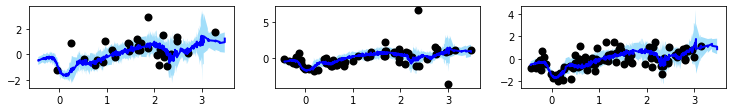

In [ ]:
# visualisation for one light curve w/ increasing number of points

def viz_per_example(lc, net, k_iwae=40, n_max=10, fracs=[0.2,0.2,0.5]): 
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    lc = lc[np.newaxis, :,:]

    np.random.seed(0)
    with torch.no_grad():
        for frac in fracs: # 
            if torch.is_tensor(lc):
                lc = lc.cpu().numpy()

            # make new masks relative to fraction of points we got to predict w/ 
            smask, rmask = my_utils.make_masks(lc, frac=frac)

            # plug em in 
            lc[:,:,3:4] = smask[:,:, np.newaxis]
            lc[:,:,4:5] = rmask[:,:, np.newaxis]
            # CUDA~
            lc = torch.tensor(lc)
            lc = lc.to(device)
            
            subsampled_mask = lc[:,:,3:4]
            seqlen = lc.size(0)
            # 
            context_y = torch.cat((lc[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
            # probabilities per batch?  

            px, _ = net.get_reconstruction(lc[:,:, 0], context_y, lc[:,:, 0], num_samples=k_iwae)
            pred_mean.append(px.mean.cpu().numpy()) # (10,batch_size, seq len,1)
            # changing from logvar to std 
            pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())

            targets.append((lc[:,:, 1:2]).cpu().numpy())
            masks.append(subsampled_mask.cpu().numpy())
            tp.append(lc[:,:, 0].cpu().numpy())
            
    #             # how many batches of predictions for each frac?

    # # 10 samples per light curve, 48 light curves, 621, 1
    # # first 16 are frac[0], second 16 are frac[1], 
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    # inputs = np.ma.masked_where(masks < 1., targets)
    print(f'pred_mean: {pred_mean.shape}', f'pred_std: {pred_std.shape}=', f'targets: {targets.shape}', f'masks: {masks.shape}', f'tps: {tp.shape}', f'inputs: {inputs.shape}')
    # we're are sampling from the intermediate representation w/ k_iwae
    # then we sample from the means/stds from the intermediate representation w/ k_iwae
    
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    print(preds.shape)
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.859, axis=0)
    quantile1 = np.quantile(preds, 0.141, axis=0)
    
    w = 2.0
    plt.figure(figsize=(12.5, 1.5))
    for j in range(3):
        plt.subplot(1, 3, j + 1)
        plt.fill_between(tp[j], quantile1[j, :, 0], quantile2[j, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
        plt.plot(tp[j], median[j, :, 0], c='b', lw=w, label='Reconstructions')
        #plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
        plt.scatter(tp[j], inputs[j, :, 0], c='k', lw=w, label='Observed Data')
    plt.show()

viz_per_example(lcs[1], net, k_iwae=10, n_max=10, fracs=[0.05,0.1,0.15])

(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 8, 621, 1)
(10, 48, 621, 1) (10, 48, 621, 1) (48, 621, 1) (48, 621, 1) (48, 621)
(50, 48, 621, 1)
pay attention (48, 621, 1)
[[[[ 9.09027851e-01]
   [ 1.46466796e-01]
   [ 4.69158486e-01]
   ...
   [ 7.29860659e-01]
   [-9.38114953e-01]
   [ 3.64272914e-01]]

  [[-2.69431811e-01]
   [-1.79806794e-01]
   [-2.24539449e-01]
   ...
   [-6.83035487e-01]
   [ 1.26276778e+00]
   [ 8.74045848e-03]]

  [[ 2.46164020e-01]
   [ 1.30924471e-01]
   [ 1.91831819e-01]
   ...
   [-4.52828943e-01]
   [-3.81047257e-01]
   [-3.98608627e-01]]

  ...

  [[ 2.70634397e+00]
   [ 2.62342101e+00]
   [ 2.74485907e+00]
   ...
   [ 2.88627561e+00]
   [ 2.77657158e+00]
   [ 2.59475730e+00]]

  [[ 3.62404972e+00]
   [ 3.59708575e+00]
   [ 3.71453739e+00]
   ...
   [ 3.42863729e+00]
   [ 3.53679498e+00]
   [ 3.41859824e+00]]

  [[ 1.67939029e+01]
   [ 1.73144736e+01]
   [ 1.68208746e+01]
   ...
   [ 1.52949189e+01]
   [ 1.68982334e+

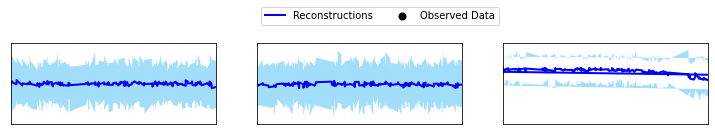

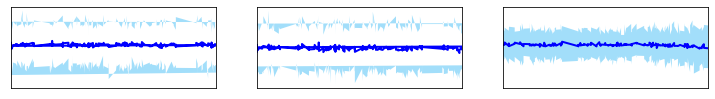

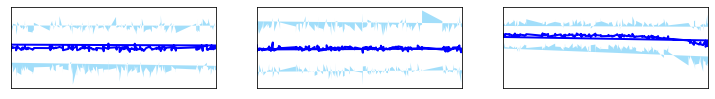

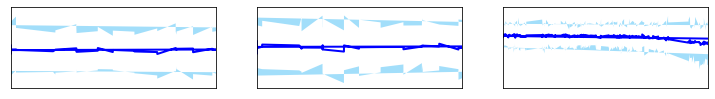

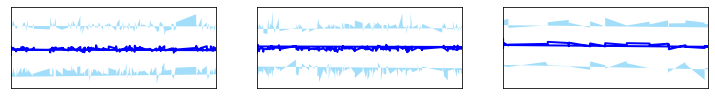

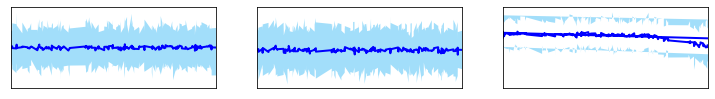

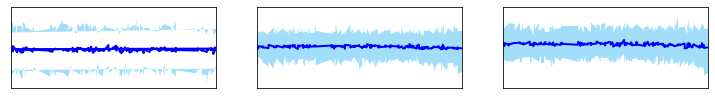

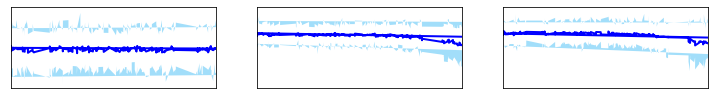

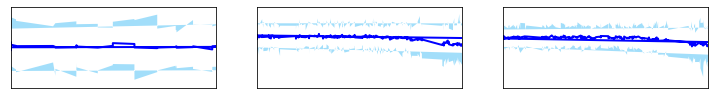

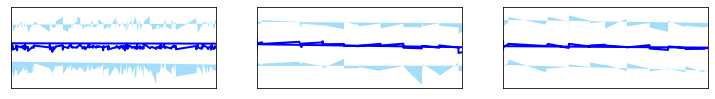